# BipedalWalker-v2 with A2C, Vectorized Environment
In this notebook, you will implement a PPO agent with OpenAI Gym's BipedalWalker-v2 environment.

### 1. Create Vectorized Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from  collections  import deque
import time
from model import Policy

from a2c_Adam import a2c_agent
from storage import RolloutStorage
from utils import get_render_func, get_vec_normalize


from parallelEnv import parallelEnv
import matplotlib.pyplot as plt
%matplotlib inline

print('gym version: ', gym.__version__)
print('torch version: ', torch.__version__)

seed = 0 
gamma=0.99
num_processes=16 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

envs = parallelEnv('BipedalWalker-v2', n=num_processes, seed=seed)

## make_vec_envs -cannot find context for 'forkserver'
## forkserver is only available in Python 3.4+ and only on some Unix platforms (not on Windows).
## envs = make_vec_envs('BipedalWalker-v2', \
##                    seed + 1000, num_processes,
##                    None, None, False, device='cpu', allow_early_resets=False)

max_steps = envs.max_steps
print('max_steps: ', max_steps)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)


gym version:  0.13.1
torch version:  1.0.1
device:  cuda:0
max_steps:  1600


### 2. Instantiate Model, Agent and Storage

Initialize the Policy (model MLPBase), PPO Agent and Rollout Storage.

In [2]:
## model Policy uses MLPBase
policy = Policy(envs.observation_space.shape, envs.action_space,\
        base_kwargs={'recurrent': False})

policy.to(device)

## optim.Adam, lr = 0.0005
agent = a2c_agent(actor_critic=policy, value_loss_coef=0.5, entropy_coef=0.01,\
            lr=0.0005, eps=1e-5, max_grad_norm=0.5)

rollouts = RolloutStorage(num_steps=max_steps, num_processes=num_processes, \
                        obs_shape=envs.observation_space.shape, action_space=envs.action_space, \
                        recurrent_hidden_state_size=policy.recurrent_hidden_state_size)

obs = envs.reset()
print('type obs: ', type(obs), ', shape obs: ', obs.shape)
obs_t = torch.tensor(obs)
print('type obs_t: ', type(obs_t), ', shape obs_t: ', obs_t.shape)

rollouts.obs[0].copy_(obs_t)
rollouts.to(device)


type obs:  <class 'numpy.ndarray'> , shape obs:  (16, 24)
type obs_t:  <class 'torch.Tensor'> , shape obs_t:  torch.Size([16, 24])


### 3.Save model function

In [3]:
def save(model, directory, filename, suffix):
    torch.save(model.base.actor.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic_linear.state_dict(), '%s/%s_critic_linear_%s.pth' % (directory, filename, suffix))
    
limits = [-300, -160, -100, -70, -50, 0, 20, 30, 40, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf      

### 4. Train the Agent  with Vectorized Environment

In [4]:
num_updates=1000000
gamma = 0.99
tau=0.95
save_interval=30
log_interval= 1 

def a2c_vec_env_train(envs, agent, policy, num_processes, num_steps, rollouts):
    
    time_start = time.time()
    
    n=len(envs.ps)    
    envs.reset()
    
    # start all parallel agents
    print('Number of agents: ', n)
    envs.step([[1]*4]*n)
    
    s = 0
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    for i_episode in range(num_updates):
        
        total_reward = np.zeros(n)
        timestep = 0
        
        for timestep in range(num_steps):

            with torch.no_grad():
                value, actions, action_log_prob, recurrent_hidden_states = \
                   policy.act(
                        rollouts.obs[timestep],
                        rollouts.recurrent_hidden_states[timestep],
                        rollouts.masks[timestep])
                
            obs, rewards, done, infos = envs.step(actions.cpu().detach().numpy())
            
            total_reward += rewards  ## this is the list by agents
                        
            # If done then clean the history of observations.
            masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
            obs_t = torch.tensor(obs)
            ## Add one dimnesion to tensor, otherwise does not work
            ## This is (unsqueeze(1)) solution for:
            ## RuntimeError: The expanded size of the tensor (1) must match the existing size...
            rewards_t = torch.tensor(rewards).unsqueeze(1)
            rollouts.insert(obs_t, recurrent_hidden_states, actions, action_log_prob, \
                value, rewards_t, masks)
                    
        avg_total_reward = np.mean(total_reward)
        scores_deque.append(avg_total_reward)
        scores_array.append(avg_total_reward)
                
        with torch.no_grad():
            next_value = policy.get_value(rollouts.obs[-1],
                            rollouts.recurrent_hidden_states[-1],
                            rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, gamma, tau)

        agent.update(rollouts)

        rollouts.after_update()
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        if i_episode > 0 and i_episode % save_interval == 0:
            print('Saving model, i_episode: ', i_episode, '\n')
            suf = return_suffix(avg_score)
            save(policy, 'dir_chk', 'weights_a2c', suf)
            #save_venv(policy, 'dir_save_VecEnv', 'final')

        
        if i_episode % log_interval == 0 and len(scores_deque) > 1:            
            prev_s = s
            s = (int)(time.time() - time_start)
            t_del = s - prev_s
            print('Ep. {}, Timesteps {}, Score.Agents: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}, \
Interval: {:02}:{:02}'\
                   .format(i_episode, timestep+1, \
                        avg_total_reward, avg_score, s//3600, s%3600//60, s%60, t_del%3600//60, t_del%60)) 
    
        if len(scores_deque) == 100 and np.mean(scores_deque) > 300.5:   
            print('Environment solved with Average Score: ',  np.mean(scores_deque) )
            break
    
    
    return scores_array, avg_scores_array
            

In [5]:
scores, avg_scores = a2c_vec_env_train(envs, agent, policy, num_processes, max_steps, rollouts)


Number of agents:  16
Ep. 1, Timesteps 1600, Score.Agents: -856.61, Avg.Score: -1018.83, Time: 00:00:38, Interval: 00:38
Ep. 2, Timesteps 1600, Score.Agents: -718.07, Avg.Score: -918.58, Time: 00:00:55, Interval: 00:17
Ep. 3, Timesteps 1600, Score.Agents: -817.02, Avg.Score: -893.19, Time: 00:01:13, Interval: 00:18
Ep. 4, Timesteps 1600, Score.Agents: -656.89, Avg.Score: -845.93, Time: 00:01:31, Interval: 00:18
Ep. 5, Timesteps 1600, Score.Agents: -652.01, Avg.Score: -813.61, Time: 00:01:50, Interval: 00:19
Ep. 6, Timesteps 1600, Score.Agents: -660.80, Avg.Score: -791.78, Time: 00:02:13, Interval: 00:23
Ep. 7, Timesteps 1600, Score.Agents: -533.41, Avg.Score: -759.48, Time: 00:02:33, Interval: 00:20
Ep. 8, Timesteps 1600, Score.Agents: -792.65, Avg.Score: -763.17, Time: 00:02:51, Interval: 00:18
Ep. 9, Timesteps 1600, Score.Agents: -482.23, Avg.Score: -735.08, Time: 00:03:08, Interval: 00:17
Ep. 10, Timesteps 1600, Score.Agents: -443.04, Avg.Score: -708.53, Time: 00:03:26, Interval: 00

Ep. 84, Timesteps 1600, Score.Agents: -94.11, Avg.Score: -237.48, Time: 00:24:35, Interval: 00:17
Ep. 85, Timesteps 1600, Score.Agents: -118.98, Avg.Score: -236.11, Time: 00:24:51, Interval: 00:16
Ep. 86, Timesteps 1600, Score.Agents: -108.94, Avg.Score: -234.64, Time: 00:25:08, Interval: 00:17
Ep. 87, Timesteps 1600, Score.Agents: -91.58, Avg.Score: -233.02, Time: 00:25:24, Interval: 00:16
Ep. 88, Timesteps 1600, Score.Agents: -100.91, Avg.Score: -231.53, Time: 00:25:41, Interval: 00:17
Ep. 89, Timesteps 1600, Score.Agents: -97.69, Avg.Score: -230.05, Time: 00:25:58, Interval: 00:17
Saving model, i_episode:  90 

Ep. 90, Timesteps 1600, Score.Agents: -81.46, Avg.Score: -228.41, Time: 00:26:14, Interval: 00:16
Ep. 91, Timesteps 1600, Score.Agents: -83.14, Avg.Score: -226.84, Time: 00:26:30, Interval: 00:16
Ep. 92, Timesteps 1600, Score.Agents: -99.70, Avg.Score: -225.47, Time: 00:26:47, Interval: 00:17
Ep. 93, Timesteps 1600, Score.Agents: -100.39, Avg.Score: -224.14, Time: 00:27:04, I

Ep. 167, Timesteps 1600, Score.Agents: -41.40, Avg.Score: -76.96, Time: 00:50:14, Interval: 00:20
Ep. 168, Timesteps 1600, Score.Agents: -36.34, Avg.Score: -76.30, Time: 00:50:33, Interval: 00:19
Ep. 169, Timesteps 1600, Score.Agents: -32.17, Avg.Score: -75.41, Time: 00:50:51, Interval: 00:18
Ep. 170, Timesteps 1600, Score.Agents: -31.14, Avg.Score: -74.56, Time: 00:51:10, Interval: 00:19
Ep. 171, Timesteps 1600, Score.Agents: -47.67, Avg.Score: -73.87, Time: 00:51:28, Interval: 00:18
Ep. 172, Timesteps 1600, Score.Agents: -32.54, Avg.Score: -73.13, Time: 00:51:46, Interval: 00:18
Ep. 173, Timesteps 1600, Score.Agents: -48.79, Avg.Score: -72.70, Time: 00:52:03, Interval: 00:17
Ep. 174, Timesteps 1600, Score.Agents: -34.67, Avg.Score: -72.12, Time: 00:52:21, Interval: 00:18
Ep. 175, Timesteps 1600, Score.Agents: -33.98, Avg.Score: -71.02, Time: 00:52:38, Interval: 00:17
Ep. 176, Timesteps 1600, Score.Agents: -24.62, Avg.Score: -70.31, Time: 00:52:55, Interval: 00:17
Ep. 177, Timesteps 1

Ep. 251, Timesteps 1600, Score.Agents: 46.61, Avg.Score: -2.80, Time: 01:15:00, Interval: 00:18
Ep. 252, Timesteps 1600, Score.Agents: 40.00, Avg.Score: -1.95, Time: 01:15:18, Interval: 00:18
Ep. 253, Timesteps 1600, Score.Agents: 25.09, Avg.Score: -1.12, Time: 01:15:36, Interval: 00:18
Ep. 254, Timesteps 1600, Score.Agents: 49.27, Avg.Score: -0.17, Time: 01:15:54, Interval: 00:18
Ep. 255, Timesteps 1600, Score.Agents: 52.87, Avg.Score: 0.86, Time: 01:16:13, Interval: 00:19
Ep. 256, Timesteps 1600, Score.Agents: 36.49, Avg.Score: 1.65, Time: 01:16:32, Interval: 00:19
Ep. 257, Timesteps 1600, Score.Agents: 27.13, Avg.Score: 2.36, Time: 01:16:52, Interval: 00:20
Ep. 258, Timesteps 1600, Score.Agents: 41.93, Avg.Score: 3.23, Time: 01:17:09, Interval: 00:17
Ep. 259, Timesteps 1600, Score.Agents: 50.37, Avg.Score: 4.27, Time: 01:17:27, Interval: 00:18
Ep. 260, Timesteps 1600, Score.Agents: 30.95, Avg.Score: 5.16, Time: 01:17:45, Interval: 00:18
Ep. 261, Timesteps 1600, Score.Agents: 42.40, 

Ep. 336, Timesteps 1600, Score.Agents: 80.87, Avg.Score: 53.80, Time: 01:40:17, Interval: 00:18
Ep. 337, Timesteps 1600, Score.Agents: 64.87, Avg.Score: 54.26, Time: 01:40:36, Interval: 00:19
Ep. 338, Timesteps 1600, Score.Agents: 83.71, Avg.Score: 54.73, Time: 01:40:59, Interval: 00:23
Ep. 339, Timesteps 1600, Score.Agents: 76.71, Avg.Score: 55.34, Time: 01:41:19, Interval: 00:20
Ep. 340, Timesteps 1600, Score.Agents: 78.38, Avg.Score: 55.68, Time: 01:41:38, Interval: 00:19
Ep. 341, Timesteps 1600, Score.Agents: 66.43, Avg.Score: 56.05, Time: 01:41:57, Interval: 00:19
Ep. 342, Timesteps 1600, Score.Agents: 76.49, Avg.Score: 56.53, Time: 01:42:15, Interval: 00:18
Ep. 343, Timesteps 1600, Score.Agents: 70.29, Avg.Score: 56.71, Time: 01:42:34, Interval: 00:19
Ep. 344, Timesteps 1600, Score.Agents: 33.65, Avg.Score: 56.57, Time: 01:42:54, Interval: 00:20
Ep. 345, Timesteps 1600, Score.Agents: 88.57, Avg.Score: 57.17, Time: 01:43:13, Interval: 00:19
Ep. 346, Timesteps 1600, Score.Agents: 6

Ep. 421, Timesteps 1600, Score.Agents: 103.42, Avg.Score: 79.20, Time: 02:07:02, Interval: 00:18
Ep. 422, Timesteps 1600, Score.Agents: 100.01, Avg.Score: 79.80, Time: 02:07:21, Interval: 00:19
Ep. 423, Timesteps 1600, Score.Agents: 100.89, Avg.Score: 80.10, Time: 02:07:40, Interval: 00:19
Ep. 424, Timesteps 1600, Score.Agents: 83.24, Avg.Score: 80.38, Time: 02:07:58, Interval: 00:18
Ep. 425, Timesteps 1600, Score.Agents: 114.34, Avg.Score: 80.95, Time: 02:08:17, Interval: 00:19
Ep. 426, Timesteps 1600, Score.Agents: 93.25, Avg.Score: 81.05, Time: 02:08:34, Interval: 00:17
Ep. 427, Timesteps 1600, Score.Agents: 103.40, Avg.Score: 81.25, Time: 02:08:53, Interval: 00:19
Ep. 428, Timesteps 1600, Score.Agents: 93.37, Avg.Score: 81.42, Time: 02:09:10, Interval: 00:17
Ep. 429, Timesteps 1600, Score.Agents: 103.18, Avg.Score: 81.88, Time: 02:09:28, Interval: 00:18
Ep. 430, Timesteps 1600, Score.Agents: 87.48, Avg.Score: 82.03, Time: 02:09:49, Interval: 00:21
Ep. 431, Timesteps 1600, Score.Age

Ep. 506, Timesteps 1600, Score.Agents: 73.32, Avg.Score: 95.99, Time: 02:34:15, Interval: 00:20
Ep. 507, Timesteps 1600, Score.Agents: 95.11, Avg.Score: 96.11, Time: 02:34:35, Interval: 00:20
Ep. 508, Timesteps 1600, Score.Agents: 97.35, Avg.Score: 96.20, Time: 02:35:01, Interval: 00:26
Ep. 509, Timesteps 1600, Score.Agents: 102.91, Avg.Score: 96.46, Time: 02:35:21, Interval: 00:20
Saving model, i_episode:  510 

Ep. 510, Timesteps 1600, Score.Agents: 106.84, Avg.Score: 96.74, Time: 02:35:39, Interval: 00:18
Ep. 511, Timesteps 1600, Score.Agents: 98.71, Avg.Score: 96.85, Time: 02:35:59, Interval: 00:20
Ep. 512, Timesteps 1600, Score.Agents: 119.52, Avg.Score: 97.24, Time: 02:36:18, Interval: 00:19
Ep. 513, Timesteps 1600, Score.Agents: 120.94, Avg.Score: 97.66, Time: 02:36:37, Interval: 00:19
Ep. 514, Timesteps 1600, Score.Agents: 120.38, Avg.Score: 98.03, Time: 02:36:56, Interval: 00:19
Ep. 515, Timesteps 1600, Score.Agents: 121.21, Avg.Score: 98.49, Time: 02:37:17, Interval: 00:21
Ep

Ep. 589, Timesteps 1600, Score.Agents: 130.60, Avg.Score: 111.00, Time: 03:00:50, Interval: 00:18
Ep. 590, Timesteps 1600, Score.Agents: 135.38, Avg.Score: 111.45, Time: 03:01:08, Interval: 00:18
Ep. 591, Timesteps 1600, Score.Agents: 106.78, Avg.Score: 111.44, Time: 03:01:26, Interval: 00:18
Ep. 592, Timesteps 1600, Score.Agents: 138.31, Avg.Score: 112.16, Time: 03:01:43, Interval: 00:17
Ep. 593, Timesteps 1600, Score.Agents: 137.10, Avg.Score: 112.70, Time: 03:02:00, Interval: 00:17
Ep. 594, Timesteps 1600, Score.Agents: 110.28, Avg.Score: 112.64, Time: 03:02:17, Interval: 00:17
Ep. 595, Timesteps 1600, Score.Agents: 96.34, Avg.Score: 112.96, Time: 03:02:34, Interval: 00:17
Ep. 596, Timesteps 1600, Score.Agents: 117.74, Avg.Score: 113.01, Time: 03:02:51, Interval: 00:17
Ep. 597, Timesteps 1600, Score.Agents: 132.39, Avg.Score: 113.21, Time: 03:03:08, Interval: 00:17
Ep. 598, Timesteps 1600, Score.Agents: 127.21, Avg.Score: 113.49, Time: 03:03:25, Interval: 00:17
Ep. 599, Timesteps 16

Ep. 672, Timesteps 1600, Score.Agents: 140.56, Avg.Score: 124.21, Time: 03:26:21, Interval: 00:17
Ep. 673, Timesteps 1600, Score.Agents: 141.14, Avg.Score: 124.46, Time: 03:26:40, Interval: 00:19
Ep. 674, Timesteps 1600, Score.Agents: 120.94, Avg.Score: 124.55, Time: 03:26:59, Interval: 00:19
Ep. 675, Timesteps 1600, Score.Agents: 139.02, Avg.Score: 124.56, Time: 03:27:18, Interval: 00:19
Ep. 676, Timesteps 1600, Score.Agents: 127.95, Avg.Score: 124.74, Time: 03:27:37, Interval: 00:19
Ep. 677, Timesteps 1600, Score.Agents: 130.35, Avg.Score: 124.96, Time: 03:27:55, Interval: 00:18
Ep. 678, Timesteps 1600, Score.Agents: 132.94, Avg.Score: 125.35, Time: 03:28:12, Interval: 00:17
Ep. 679, Timesteps 1600, Score.Agents: 146.54, Avg.Score: 125.54, Time: 03:28:29, Interval: 00:17
Ep. 680, Timesteps 1600, Score.Agents: 109.52, Avg.Score: 125.56, Time: 03:28:47, Interval: 00:18
Ep. 681, Timesteps 1600, Score.Agents: 118.81, Avg.Score: 125.52, Time: 03:29:06, Interval: 00:19
Ep. 682, Timesteps 1

Ep. 755, Timesteps 1600, Score.Agents: 138.15, Avg.Score: 129.22, Time: 03:51:08, Interval: 00:17
Ep. 756, Timesteps 1600, Score.Agents: 149.47, Avg.Score: 129.37, Time: 03:51:26, Interval: 00:18
Ep. 757, Timesteps 1600, Score.Agents: 121.93, Avg.Score: 129.31, Time: 03:51:44, Interval: 00:18
Ep. 758, Timesteps 1600, Score.Agents: 137.71, Avg.Score: 129.33, Time: 03:52:02, Interval: 00:18
Ep. 759, Timesteps 1600, Score.Agents: 124.81, Avg.Score: 129.21, Time: 03:52:19, Interval: 00:17
Ep. 760, Timesteps 1600, Score.Agents: 123.75, Avg.Score: 129.10, Time: 03:52:36, Interval: 00:17
Ep. 761, Timesteps 1600, Score.Agents: 124.70, Avg.Score: 129.10, Time: 03:52:55, Interval: 00:19
Ep. 762, Timesteps 1600, Score.Agents: 125.23, Avg.Score: 129.03, Time: 03:53:12, Interval: 00:17
Ep. 763, Timesteps 1600, Score.Agents: 132.23, Avg.Score: 128.96, Time: 03:53:29, Interval: 00:17
Ep. 764, Timesteps 1600, Score.Agents: 143.54, Avg.Score: 129.20, Time: 03:53:48, Interval: 00:19
Ep. 765, Timesteps 1

Ep. 838, Timesteps 1600, Score.Agents: 140.30, Avg.Score: 136.14, Time: 04:15:53, Interval: 00:19
Ep. 839, Timesteps 1600, Score.Agents: 141.71, Avg.Score: 136.15, Time: 04:16:14, Interval: 00:21
Saving model, i_episode:  840 

Ep. 840, Timesteps 1600, Score.Agents: 139.88, Avg.Score: 136.39, Time: 04:16:40, Interval: 00:26
Ep. 841, Timesteps 1600, Score.Agents: 139.39, Avg.Score: 136.52, Time: 04:17:04, Interval: 00:24
Ep. 842, Timesteps 1600, Score.Agents: 109.05, Avg.Score: 136.18, Time: 04:17:26, Interval: 00:22
Ep. 843, Timesteps 1600, Score.Agents: 133.67, Avg.Score: 136.03, Time: 04:17:45, Interval: 00:19
Ep. 844, Timesteps 1600, Score.Agents: 150.68, Avg.Score: 136.43, Time: 04:18:04, Interval: 00:19
Ep. 845, Timesteps 1600, Score.Agents: 143.11, Avg.Score: 136.50, Time: 04:18:25, Interval: 00:21
Ep. 846, Timesteps 1600, Score.Agents: 136.87, Avg.Score: 136.60, Time: 04:18:48, Interval: 00:23
Ep. 847, Timesteps 1600, Score.Agents: 119.52, Avg.Score: 136.61, Time: 04:19:08, Inte

Ep. 921, Timesteps 1600, Score.Agents: 156.36, Avg.Score: 139.20, Time: 04:45:15, Interval: 00:30
Ep. 922, Timesteps 1600, Score.Agents: 159.64, Avg.Score: 139.24, Time: 04:45:46, Interval: 00:31
Ep. 923, Timesteps 1600, Score.Agents: 145.42, Avg.Score: 139.33, Time: 04:46:16, Interval: 00:30
Ep. 924, Timesteps 1600, Score.Agents: 152.34, Avg.Score: 139.38, Time: 04:46:53, Interval: 00:37
Ep. 925, Timesteps 1600, Score.Agents: 162.15, Avg.Score: 139.61, Time: 04:47:29, Interval: 00:36
Ep. 926, Timesteps 1600, Score.Agents: 162.62, Avg.Score: 139.80, Time: 04:48:05, Interval: 00:36
Ep. 927, Timesteps 1600, Score.Agents: 150.49, Avg.Score: 139.96, Time: 04:48:36, Interval: 00:31
Ep. 928, Timesteps 1600, Score.Agents: 132.87, Avg.Score: 139.99, Time: 04:49:06, Interval: 00:30
Ep. 929, Timesteps 1600, Score.Agents: 144.14, Avg.Score: 140.13, Time: 04:49:35, Interval: 00:29
Saving model, i_episode:  930 

Ep. 930, Timesteps 1600, Score.Agents: 154.16, Avg.Score: 140.22, Time: 04:50:04, Inte

Ep. 1004, Timesteps 1600, Score.Agents: 129.70, Avg.Score: 148.93, Time: 05:25:08, Interval: 00:28
Ep. 1005, Timesteps 1600, Score.Agents: 136.51, Avg.Score: 149.01, Time: 05:25:36, Interval: 00:28
Ep. 1006, Timesteps 1600, Score.Agents: 160.74, Avg.Score: 149.26, Time: 05:26:04, Interval: 00:28
Ep. 1007, Timesteps 1600, Score.Agents: 163.00, Avg.Score: 149.36, Time: 05:26:31, Interval: 00:27
Ep. 1008, Timesteps 1600, Score.Agents: 142.92, Avg.Score: 149.39, Time: 05:26:59, Interval: 00:28
Ep. 1009, Timesteps 1600, Score.Agents: 96.62, Avg.Score: 148.76, Time: 05:27:27, Interval: 00:28
Ep. 1010, Timesteps 1600, Score.Agents: 152.82, Avg.Score: 148.97, Time: 05:27:55, Interval: 00:28
Ep. 1011, Timesteps 1600, Score.Agents: 144.82, Avg.Score: 149.28, Time: 05:28:22, Interval: 00:27
Ep. 1012, Timesteps 1600, Score.Agents: 137.08, Avg.Score: 149.37, Time: 05:28:50, Interval: 00:28
Ep. 1013, Timesteps 1600, Score.Agents: 156.60, Avg.Score: 149.45, Time: 05:29:17, Interval: 00:27
Ep. 1014, T

Ep. 1086, Timesteps 1600, Score.Agents: 149.65, Avg.Score: 147.46, Time: 06:03:00, Interval: 00:28
Ep. 1087, Timesteps 1600, Score.Agents: 136.58, Avg.Score: 147.27, Time: 06:03:27, Interval: 00:27
Ep. 1088, Timesteps 1600, Score.Agents: 134.81, Avg.Score: 147.27, Time: 06:03:56, Interval: 00:29
Ep. 1089, Timesteps 1600, Score.Agents: 165.98, Avg.Score: 147.44, Time: 06:04:24, Interval: 00:28
Ep. 1090, Timesteps 1600, Score.Agents: 168.47, Avg.Score: 147.49, Time: 06:04:51, Interval: 00:27
Ep. 1091, Timesteps 1600, Score.Agents: 151.88, Avg.Score: 147.71, Time: 06:05:19, Interval: 00:28
Ep. 1092, Timesteps 1600, Score.Agents: 152.57, Avg.Score: 147.67, Time: 06:05:47, Interval: 00:28
Ep. 1093, Timesteps 1600, Score.Agents: 155.33, Avg.Score: 147.65, Time: 06:06:14, Interval: 00:27
Ep. 1094, Timesteps 1600, Score.Agents: 153.21, Avg.Score: 147.85, Time: 06:06:42, Interval: 00:28
Ep. 1095, Timesteps 1600, Score.Agents: 161.44, Avg.Score: 147.98, Time: 06:07:10, Interval: 00:28
Ep. 1096, 

Ep. 1169, Timesteps 1600, Score.Agents: 160.36, Avg.Score: 158.15, Time: 06:41:24, Interval: 00:28
Saving model, i_episode:  1170 

Ep. 1170, Timesteps 1600, Score.Agents: 140.77, Avg.Score: 158.03, Time: 06:41:52, Interval: 00:28
Ep. 1171, Timesteps 1600, Score.Agents: 175.78, Avg.Score: 158.08, Time: 06:42:19, Interval: 00:27
Ep. 1172, Timesteps 1600, Score.Agents: 180.15, Avg.Score: 158.42, Time: 06:42:47, Interval: 00:28
Ep. 1173, Timesteps 1600, Score.Agents: 168.58, Avg.Score: 158.53, Time: 06:43:15, Interval: 00:28
Ep. 1174, Timesteps 1600, Score.Agents: 167.38, Avg.Score: 158.73, Time: 06:43:42, Interval: 00:27
Ep. 1175, Timesteps 1600, Score.Agents: 172.86, Avg.Score: 158.81, Time: 06:44:10, Interval: 00:28
Ep. 1176, Timesteps 1600, Score.Agents: 156.77, Avg.Score: 158.83, Time: 06:44:38, Interval: 00:28
Ep. 1177, Timesteps 1600, Score.Agents: 164.85, Avg.Score: 158.89, Time: 06:45:05, Interval: 00:27
Ep. 1178, Timesteps 1600, Score.Agents: 167.40, Avg.Score: 159.00, Time: 06:

Ep. 1251, Timesteps 1600, Score.Agents: 153.80, Avg.Score: 160.60, Time: 07:19:49, Interval: 00:27
Ep. 1252, Timesteps 1600, Score.Agents: 160.06, Avg.Score: 160.63, Time: 07:20:18, Interval: 00:29
Ep. 1253, Timesteps 1600, Score.Agents: 166.60, Avg.Score: 160.73, Time: 07:20:45, Interval: 00:27
Ep. 1254, Timesteps 1600, Score.Agents: 158.13, Avg.Score: 160.60, Time: 07:21:12, Interval: 00:27
Ep. 1255, Timesteps 1600, Score.Agents: 161.65, Avg.Score: 160.54, Time: 07:21:39, Interval: 00:27
Ep. 1256, Timesteps 1600, Score.Agents: 154.47, Avg.Score: 160.60, Time: 07:22:07, Interval: 00:28
Ep. 1257, Timesteps 1600, Score.Agents: 172.58, Avg.Score: 160.57, Time: 07:22:35, Interval: 00:28
Ep. 1258, Timesteps 1600, Score.Agents: 131.65, Avg.Score: 160.11, Time: 07:23:02, Interval: 00:27
Ep. 1259, Timesteps 1600, Score.Agents: 152.13, Avg.Score: 159.99, Time: 07:23:30, Interval: 00:28
Saving model, i_episode:  1260 

Ep. 1260, Timesteps 1600, Score.Agents: 154.78, Avg.Score: 159.78, Time: 07:

Ep. 1333, Timesteps 1600, Score.Agents: 158.50, Avg.Score: 160.85, Time: 07:57:39, Interval: 00:27
Ep. 1334, Timesteps 1600, Score.Agents: 166.56, Avg.Score: 161.02, Time: 07:58:07, Interval: 00:28
Ep. 1335, Timesteps 1600, Score.Agents: 172.26, Avg.Score: 161.27, Time: 07:58:34, Interval: 00:27
Ep. 1336, Timesteps 1600, Score.Agents: 142.49, Avg.Score: 161.02, Time: 07:59:02, Interval: 00:28
Ep. 1337, Timesteps 1600, Score.Agents: 173.62, Avg.Score: 161.14, Time: 07:59:29, Interval: 00:27
Ep. 1338, Timesteps 1600, Score.Agents: 161.50, Avg.Score: 161.22, Time: 07:59:57, Interval: 00:28
Ep. 1339, Timesteps 1600, Score.Agents: 170.61, Avg.Score: 161.45, Time: 08:00:24, Interval: 00:27
Ep. 1340, Timesteps 1600, Score.Agents: 172.46, Avg.Score: 161.61, Time: 08:00:52, Interval: 00:28
Ep. 1341, Timesteps 1600, Score.Agents: 172.56, Avg.Score: 161.68, Time: 08:01:20, Interval: 00:28
Ep. 1342, Timesteps 1600, Score.Agents: 170.41, Avg.Score: 161.91, Time: 08:01:47, Interval: 00:27
Ep. 1343, 

Ep. 1415, Timesteps 1600, Score.Agents: 128.47, Avg.Score: 161.98, Time: 08:35:48, Interval: 00:28
Ep. 1416, Timesteps 1600, Score.Agents: 127.71, Avg.Score: 161.49, Time: 08:36:16, Interval: 00:28
Ep. 1417, Timesteps 1600, Score.Agents: 126.95, Avg.Score: 161.29, Time: 08:36:43, Interval: 00:27
Ep. 1418, Timesteps 1600, Score.Agents: 129.55, Avg.Score: 160.99, Time: 08:37:11, Interval: 00:28
Ep. 1419, Timesteps 1600, Score.Agents: 171.39, Avg.Score: 161.24, Time: 08:37:39, Interval: 00:28
Ep. 1420, Timesteps 1600, Score.Agents: 100.13, Avg.Score: 160.62, Time: 08:38:07, Interval: 00:28
Ep. 1421, Timesteps 1600, Score.Agents: 139.67, Avg.Score: 160.39, Time: 08:38:34, Interval: 00:27
Ep. 1422, Timesteps 1600, Score.Agents: 162.68, Avg.Score: 160.28, Time: 08:39:02, Interval: 00:28
Ep. 1423, Timesteps 1600, Score.Agents: 136.00, Avg.Score: 160.15, Time: 08:39:30, Interval: 00:28
Ep. 1424, Timesteps 1600, Score.Agents: 157.22, Avg.Score: 160.06, Time: 08:39:58, Interval: 00:28
Ep. 1425, 

Ep. 1498, Timesteps 1600, Score.Agents: 174.15, Avg.Score: 159.06, Time: 09:14:05, Interval: 00:27
Ep. 1499, Timesteps 1600, Score.Agents: 176.45, Avg.Score: 159.09, Time: 09:14:32, Interval: 00:27
Saving model, i_episode:  1500 

Ep. 1500, Timesteps 1600, Score.Agents: 182.94, Avg.Score: 159.09, Time: 09:14:59, Interval: 00:27
Ep. 1501, Timesteps 1600, Score.Agents: 182.33, Avg.Score: 159.16, Time: 09:15:27, Interval: 00:28
Ep. 1502, Timesteps 1600, Score.Agents: 184.11, Avg.Score: 159.33, Time: 09:15:54, Interval: 00:27
Ep. 1503, Timesteps 1600, Score.Agents: 185.17, Avg.Score: 159.56, Time: 09:16:21, Interval: 00:27
Ep. 1504, Timesteps 1600, Score.Agents: 147.95, Avg.Score: 159.41, Time: 09:16:49, Interval: 00:28
Ep. 1505, Timesteps 1600, Score.Agents: 179.13, Avg.Score: 159.53, Time: 09:17:17, Interval: 00:28
Ep. 1506, Timesteps 1600, Score.Agents: 165.83, Avg.Score: 159.64, Time: 09:17:44, Interval: 00:27
Ep. 1507, Timesteps 1600, Score.Agents: 179.30, Avg.Score: 159.86, Time: 09:

Ep. 1580, Timesteps 1600, Score.Agents: 151.18, Avg.Score: 173.59, Time: 09:51:51, Interval: 00:28
Ep. 1581, Timesteps 1600, Score.Agents: 179.62, Avg.Score: 173.71, Time: 09:52:19, Interval: 00:28
Ep. 1582, Timesteps 1600, Score.Agents: 168.33, Avg.Score: 173.44, Time: 09:52:47, Interval: 00:28
Ep. 1583, Timesteps 1600, Score.Agents: 146.72, Avg.Score: 173.49, Time: 09:53:15, Interval: 00:28
Ep. 1584, Timesteps 1600, Score.Agents: 195.52, Avg.Score: 173.71, Time: 09:53:42, Interval: 00:27
Ep. 1585, Timesteps 1600, Score.Agents: 134.74, Avg.Score: 173.23, Time: 09:54:10, Interval: 00:28
Ep. 1586, Timesteps 1600, Score.Agents: 181.22, Avg.Score: 173.36, Time: 09:54:37, Interval: 00:27
Ep. 1587, Timesteps 1600, Score.Agents: 146.55, Avg.Score: 173.24, Time: 09:55:05, Interval: 00:28
Ep. 1588, Timesteps 1600, Score.Agents: 119.93, Avg.Score: 172.55, Time: 09:55:33, Interval: 00:28
Ep. 1589, Timesteps 1600, Score.Agents: 147.10, Avg.Score: 172.23, Time: 09:56:01, Interval: 00:28
Saving mod

Ep. 1662, Timesteps 1600, Score.Agents: 194.98, Avg.Score: 174.83, Time: 10:29:40, Interval: 00:28
Ep. 1663, Timesteps 1600, Score.Agents: 202.45, Avg.Score: 174.98, Time: 10:30:08, Interval: 00:28
Ep. 1664, Timesteps 1600, Score.Agents: 177.86, Avg.Score: 175.00, Time: 10:30:36, Interval: 00:28
Ep. 1665, Timesteps 1600, Score.Agents: 192.52, Avg.Score: 175.11, Time: 10:31:03, Interval: 00:27
Ep. 1666, Timesteps 1600, Score.Agents: 179.52, Avg.Score: 175.32, Time: 10:31:31, Interval: 00:28
Ep. 1667, Timesteps 1600, Score.Agents: 192.06, Avg.Score: 175.49, Time: 10:31:59, Interval: 00:28
Ep. 1668, Timesteps 1600, Score.Agents: 190.58, Avg.Score: 175.66, Time: 10:32:26, Interval: 00:27
Ep. 1669, Timesteps 1600, Score.Agents: 182.03, Avg.Score: 175.66, Time: 10:32:54, Interval: 00:28
Ep. 1670, Timesteps 1600, Score.Agents: 199.66, Avg.Score: 175.88, Time: 10:33:22, Interval: 00:28
Ep. 1671, Timesteps 1600, Score.Agents: 179.97, Avg.Score: 175.78, Time: 10:33:50, Interval: 00:28
Ep. 1672, 

Ep. 1744, Timesteps 1600, Score.Agents: 231.08, Avg.Score: 195.78, Time: 11:09:22, Interval: 00:28
Ep. 1745, Timesteps 1600, Score.Agents: 216.12, Avg.Score: 196.01, Time: 11:09:50, Interval: 00:28
Ep. 1746, Timesteps 1600, Score.Agents: 216.47, Avg.Score: 196.58, Time: 11:10:20, Interval: 00:30
Ep. 1747, Timesteps 1600, Score.Agents: 214.88, Avg.Score: 196.92, Time: 11:10:49, Interval: 00:29
Ep. 1748, Timesteps 1600, Score.Agents: 213.22, Avg.Score: 196.95, Time: 11:11:17, Interval: 00:28
Ep. 1749, Timesteps 1600, Score.Agents: 197.31, Avg.Score: 197.03, Time: 11:11:45, Interval: 00:28
Ep. 1750, Timesteps 1600, Score.Agents: 213.95, Avg.Score: 197.43, Time: 11:12:14, Interval: 00:29
Ep. 1751, Timesteps 1600, Score.Agents: 195.99, Avg.Score: 197.98, Time: 11:12:42, Interval: 00:28
Ep. 1752, Timesteps 1600, Score.Agents: 225.51, Avg.Score: 198.70, Time: 11:13:12, Interval: 00:30
Ep. 1753, Timesteps 1600, Score.Agents: 196.38, Avg.Score: 198.89, Time: 11:13:45, Interval: 00:33
Ep. 1754, 

Ep. 1827, Timesteps 1600, Score.Agents: 226.70, Avg.Score: 212.85, Time: 11:49:20, Interval: 00:28
Ep. 1828, Timesteps 1600, Score.Agents: 240.05, Avg.Score: 213.11, Time: 11:49:48, Interval: 00:28
Ep. 1829, Timesteps 1600, Score.Agents: 224.11, Avg.Score: 213.16, Time: 11:50:17, Interval: 00:29
Saving model, i_episode:  1830 

Ep. 1830, Timesteps 1600, Score.Agents: 254.46, Avg.Score: 213.64, Time: 11:50:45, Interval: 00:28
Ep. 1831, Timesteps 1600, Score.Agents: 234.53, Avg.Score: 213.76, Time: 11:51:13, Interval: 00:28
Ep. 1832, Timesteps 1600, Score.Agents: 250.13, Avg.Score: 214.23, Time: 11:51:42, Interval: 00:29
Ep. 1833, Timesteps 1600, Score.Agents: 237.19, Avg.Score: 214.49, Time: 11:52:10, Interval: 00:28
Ep. 1834, Timesteps 1600, Score.Agents: 253.94, Avg.Score: 215.02, Time: 11:52:39, Interval: 00:29
Ep. 1835, Timesteps 1600, Score.Agents: 258.41, Avg.Score: 215.46, Time: 11:53:07, Interval: 00:28
Ep. 1836, Timesteps 1600, Score.Agents: 250.41, Avg.Score: 215.93, Time: 11:

Ep. 1909, Timesteps 1600, Score.Agents: 277.03, Avg.Score: 244.23, Time: 12:28:13, Interval: 00:29
Ep. 1910, Timesteps 1600, Score.Agents: 263.68, Avg.Score: 244.33, Time: 12:28:41, Interval: 00:28
Ep. 1911, Timesteps 1600, Score.Agents: 253.77, Avg.Score: 244.50, Time: 12:29:10, Interval: 00:29
Ep. 1912, Timesteps 1600, Score.Agents: 274.18, Avg.Score: 244.91, Time: 12:29:38, Interval: 00:28
Ep. 1913, Timesteps 1600, Score.Agents: 259.63, Avg.Score: 244.95, Time: 12:30:07, Interval: 00:29
Ep. 1914, Timesteps 1600, Score.Agents: 270.03, Avg.Score: 245.63, Time: 12:30:35, Interval: 00:28
Ep. 1915, Timesteps 1600, Score.Agents: 280.55, Avg.Score: 246.01, Time: 12:31:03, Interval: 00:28
Ep. 1916, Timesteps 1600, Score.Agents: 259.24, Avg.Score: 246.20, Time: 12:31:32, Interval: 00:29
Ep. 1917, Timesteps 1600, Score.Agents: 273.00, Avg.Score: 246.74, Time: 12:32:00, Interval: 00:28
Ep. 1918, Timesteps 1600, Score.Agents: 271.06, Avg.Score: 247.35, Time: 12:32:29, Interval: 00:29
Ep. 1919, 

Ep. 1991, Timesteps 1600, Score.Agents: 263.57, Avg.Score: 262.70, Time: 13:08:16, Interval: 00:30
Ep. 1992, Timesteps 1600, Score.Agents: 290.24, Avg.Score: 262.97, Time: 13:08:47, Interval: 00:31
Ep. 1993, Timesteps 1600, Score.Agents: 273.91, Avg.Score: 262.94, Time: 13:09:18, Interval: 00:31
Ep. 1994, Timesteps 1600, Score.Agents: 275.65, Avg.Score: 262.92, Time: 13:09:50, Interval: 00:32
Ep. 1995, Timesteps 1600, Score.Agents: 266.49, Avg.Score: 263.11, Time: 13:10:20, Interval: 00:30
Ep. 1996, Timesteps 1600, Score.Agents: 303.52, Avg.Score: 263.72, Time: 13:10:51, Interval: 00:31
Ep. 1997, Timesteps 1600, Score.Agents: 300.59, Avg.Score: 264.02, Time: 13:11:23, Interval: 00:32
Ep. 1998, Timesteps 1600, Score.Agents: 270.88, Avg.Score: 264.19, Time: 13:11:54, Interval: 00:31
Ep. 1999, Timesteps 1600, Score.Agents: 291.13, Avg.Score: 264.46, Time: 13:12:25, Interval: 00:31
Ep. 2000, Timesteps 1600, Score.Agents: 292.48, Avg.Score: 264.83, Time: 13:12:55, Interval: 00:30
Ep. 2001, 

Ep. 2073, Timesteps 1600, Score.Agents: 283.86, Avg.Score: 282.43, Time: 13:48:51, Interval: 00:29
Ep. 2074, Timesteps 1600, Score.Agents: 288.26, Avg.Score: 282.44, Time: 13:49:19, Interval: 00:28
Ep. 2075, Timesteps 1600, Score.Agents: 290.25, Avg.Score: 282.41, Time: 13:49:49, Interval: 00:30
Ep. 2076, Timesteps 1600, Score.Agents: 263.78, Avg.Score: 282.17, Time: 13:50:20, Interval: 00:31
Ep. 2077, Timesteps 1600, Score.Agents: 283.37, Avg.Score: 282.17, Time: 13:50:48, Interval: 00:28
Ep. 2078, Timesteps 1600, Score.Agents: 319.97, Avg.Score: 282.47, Time: 13:51:17, Interval: 00:29
Ep. 2079, Timesteps 1600, Score.Agents: 309.66, Avg.Score: 282.92, Time: 13:51:45, Interval: 00:28
Ep. 2080, Timesteps 1600, Score.Agents: 267.01, Avg.Score: 282.84, Time: 13:52:14, Interval: 00:29
Ep. 2081, Timesteps 1600, Score.Agents: 298.41, Avg.Score: 283.15, Time: 13:52:42, Interval: 00:28
Ep. 2082, Timesteps 1600, Score.Agents: 297.05, Avg.Score: 283.55, Time: 13:53:10, Interval: 00:28
Ep. 2083, 

Ep. 2156, Timesteps 1600, Score.Agents: 300.12, Avg.Score: 293.06, Time: 14:28:19, Interval: 00:29
Ep. 2157, Timesteps 1600, Score.Agents: 299.74, Avg.Score: 293.49, Time: 14:28:47, Interval: 00:28
Ep. 2158, Timesteps 1600, Score.Agents: 307.68, Avg.Score: 293.80, Time: 14:29:16, Interval: 00:29
Ep. 2159, Timesteps 1600, Score.Agents: 319.08, Avg.Score: 294.66, Time: 14:29:44, Interval: 00:28
Saving model, i_episode:  2160 

Ep. 2160, Timesteps 1600, Score.Agents: 332.98, Avg.Score: 295.37, Time: 14:30:12, Interval: 00:28
Ep. 2161, Timesteps 1600, Score.Agents: 311.10, Avg.Score: 296.06, Time: 14:30:40, Interval: 00:28
Ep. 2162, Timesteps 1600, Score.Agents: 284.45, Avg.Score: 296.66, Time: 14:31:09, Interval: 00:29
Ep. 2163, Timesteps 1600, Score.Agents: 331.23, Avg.Score: 297.25, Time: 14:31:37, Interval: 00:28
Ep. 2164, Timesteps 1600, Score.Agents: 297.94, Avg.Score: 297.50, Time: 14:32:05, Interval: 00:28
Ep. 2165, Timesteps 1600, Score.Agents: 318.48, Avg.Score: 298.00, Time: 14:

In [7]:
save(model=policy,directory='dir_chk',filename='weights_a2c',suffix='final')

length of scores:  2188 , len of avg_scores:  2188


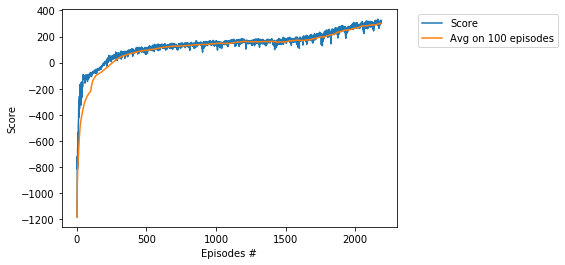

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [12]:
from envs import make_vec_envs

#--------------- make_vec_envs ----------------
## we continue with the same model, model Policy uses MLPBase, 
## but with single new environment env_venv

device = torch.device("cpu")
print('device: ', device)

seed = 0 
num_processes=1  

env_venv = make_vec_envs('BipedalWalker-v2', \
                    seed + 1000, num_processes,
                    None, None, False, device='cpu', allow_early_resets=False)

policy = policy.to(device)

print('env_venv.observation_space.shape: ', env_venv.observation_space.shape, \
      ', len(obs_shape): ', len(env_venv.observation_space.shape))
print('env_venv.action_space: ',  env_venv.action_space, \
      ', action_space.shape[0]: ', env_venv.action_space.shape[0])


device:  cpu
env_venv.observation_space.shape:  (24,) , len(obs_shape):  1
env_venv.action_space:  Box(4,) , action_space.shape[0]:  4


In [13]:
## No CUDA, only CPU

def play_VecEnv(env, model, num_episodes):

    obs = env.reset()
    obs = torch.Tensor(obs)
    obs = obs.float()
        
    recurrent_hidden_states = torch.zeros(1, model.recurrent_hidden_state_size)
    
    masks = torch.zeros(1, 1)
    
    scores_deque = deque(maxlen=100)

    render_func = get_render_func(env)
        
    for i_episode in range(1, num_episodes+1):     

        time_start = time.time()
        total_reward = np.zeros(num_processes)
        timestep = 0

        while True:
        
            with torch.no_grad():
                value, action, _, recurrent_hidden_states = \
                    model.act(obs, recurrent_hidden_states, masks, \
                    deterministic=False) # obs = state

            render_func()
            
            obs, reward, done, _ = env.step(action)
            obs = torch.Tensor(obs)
            obs = obs.float()

            reward = reward.detach().numpy()
            
            masks.fill_(0.0 if done else 1.0)
            
            total_reward += reward[0]
        
            timestep += 1
            
            if timestep + 1 == 1600: ##   envs.max_steps:
                break

        s = (int)(time.time() - time_start)
        
        scores_deque.append(total_reward[0])
        
        avg_score = np.mean(scores_deque)
                    
        print('Episode {} \tScore: {:.2f}, Avg.Score: {:.2f}, \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, total_reward[0], avg_score,  s//3600, s%3600//60, s%60))  


In [14]:
play_VecEnv(env=env_venv, model=policy, num_episodes=5)

Episode 1 	Score: 286.45, Avg.Score: 286.45, 	Time: 00:01:06
Episode 2 	Score: 342.14, Avg.Score: 314.30, 	Time: 00:00:46
Episode 3 	Score: 337.43, Avg.Score: 322.01, 	Time: 00:00:48
Episode 4 	Score: 312.83, Avg.Score: 319.71, 	Time: 00:00:48
Episode 5 	Score: 333.78, Avg.Score: 322.53, 	Time: 00:00:43


In [15]:
play_VecEnv(env=env_venv, model=policy, num_episodes=5)

Episode 1 	Score: 318.98, Avg.Score: 318.98, 	Time: 00:00:35
Episode 2 	Score: 319.76, Avg.Score: 319.37, 	Time: 00:00:34
Episode 3 	Score: 360.76, Avg.Score: 333.17, 	Time: 00:00:34
Episode 4 	Score: 331.93, Avg.Score: 332.86, 	Time: 00:00:34
Episode 5 	Score: 353.29, Avg.Score: 336.94, 	Time: 00:00:42


In [39]:
play_VecEnv(env=env_venv, model=policy, num_episodes=5)

Episode 1 	Score: 334.63, Avg.Score: 334.63, 	Time: 00:00:43
Episode 2 	Score: 329.36, Avg.Score: 331.99, 	Time: 00:00:44
Episode 3 	Score: 323.13, Avg.Score: 329.04, 	Time: 00:00:47
Episode 4 	Score: 279.78, Avg.Score: 316.73, 	Time: 00:00:44
Episode 5 	Score: 348.73, Avg.Score: 323.13, 	Time: 00:00:45


In [37]:
#env_venv.close()